In [1]:
from __future__ import annotations

import sys
import traceback
from pathlib import Path
from typing import Any, List

import numpy as np
import pandas as pd  # type: ignore[import]

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [2]:
from src.Bayesian_state.utils.load_config import MODEL_STRUCT
from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer

# Select Model
model_choice = "pmh_model"
engine_config = MODEL_STRUCT.get(model_choice)

if engine_config is None:
    raise ValueError(f"Model {model_choice} not found.")

print(f"Loaded configuration for: {model_choice}")
print(engine_config)

INFO:cat-learning:logger is running normally.


D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\logs\Run_20251225_123337.log
Loaded configuration for: pmh_model
{'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies', 'init_num': 8}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.05, 'gamma': 0.9}}}, 'agenda': ['perception_mod', 'hypo_transitions_mod', 'likelihood_mod', 'memory_mod']}


In [3]:
import importlib
import src.Bayesian_state.utils.state_grid_optimizer
import src.Bayesian_state.problems.model
import src.Bayesian_state.inference_engine.bayesian_engine
import src.Bayesian_state.problems.modules.memory

importlib.reload(src.Bayesian_state.inference_engine.bayesian_engine)
importlib.reload(src.Bayesian_state.problems.modules.memory)
importlib.reload(src.Bayesian_state.problems.model)
importlib.reload(src.Bayesian_state.utils.state_grid_optimizer)

from src.Bayesian_state.utils.state_grid_optimizer import StateModelGridOptimizer
from src.Bayesian_state.problems import StateModel

print("Modules reloaded.")

{'base_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}}, 'agenda': ['likelihood_mod', '__self__']}, 'default_model': {'modules': {}, 'agenda': ['__self__']}, 'm_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 15.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}, 'agenda': ['likelihood_mod', 'memory_mod']}, 'pmh_model': {'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies', 'init_num': 8}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'clas

In [4]:
import os
import multiprocessing

cpu_count = os.cpu_count()
print(f"Total CPU cores available: {cpu_count}")

# Recommendation: Leave 1-2 cores free for system tasks
recommended_n_jobs = max(1, cpu_count - 2)
print(f"Recommended n_jobs: {recommended_n_jobs}")

Total CPU cores available: 16
Recommended n_jobs: 14


In [5]:
# Initialize Optimizer
optimizer = StateModelGridOptimizer(
    engine_config=engine_config,
    processed_data_dir=DATA_ROOT,
    n_jobs=12 # Adjust based on your CPU cores
)
print("Optimizer initialized.")

Optimizer initialized.


In [ ]:
subject_id = 5

# Example Grid: Optimizing gamma (forgetting) and w0 (background noise)
# 都舍入到小数点后4位

# TODO：Adaptive Mesh Refinement (AMR) for more efficient search
param_grid = {
    "gamma": [0.1, 0.4, 0.7, 0.9, 0.95],
    "w0": [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.9],
    "beta": [20.,32.]
}

print(f"Starting optimization for Subject {subject_id}...")
print(f"Parameter Grid: {param_grid}")

# Run Optimization
# n_repeats: Number of runs per grid point for coarse selection
# refit_repeats: Number of runs for the best parameter set for fine estimation
results = optimizer.optimize_subject(
    subject_id=subject_id,
    param_grid=param_grid,
    n_repeats=8,        
    refit_repeats=256,    
    keep_logs=False
)

print("Optimization complete.")

INFO:cat-learning:Optimizing subject 5: 70 combos * 8 repeats = 560 tasks


Starting optimization for Subject 5...
Parameter Grid: {'gamma': [0.1, 0.4, 0.7, 0.9, 0.95], 'w0': [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.9], 'beta': [20.0, 32.0]}


Sub 5 Grid Search:  62%|██████▏   | 348/560 [02:41<01:27,  2.42it/s]

In [ ]:
# Analyze Results
best_result = results['best']

print("="*40)
print(f"Optimization Results for Subject {subject_id}")
print("="*40)
print(f"Best Parameters: {best_result.params}")
print(f"Best Mean Error: {best_result.mean_error:.6f}")
print(f"Standard Error:  {best_result.std_error:.6f}")
print("-" * 40)

# Convert grid results to DataFrame for easier viewing
grid_data = []
for res in results['grid']:
    row = res.params.copy()
    row['mean_error'] = res.mean_error
    row['std_error'] = res.std_error
    grid_data.append(row)

df_results = pd.DataFrame(grid_data)
df_results = df_results.sort_values('mean_error')

print("\nTop 5 Parameter Combinations:")
print(df_results.head(5))

Optimization Results for Subject 5
Best Parameters: {'beta': 20.0, 'gamma': 0.7, 'w0': 0.1}
Best Mean Error: 0.140948
Standard Error:  0.030760
----------------------------------------

Top 5 Parameter Combinations:
    beta  gamma    w0  mean_error  std_error
71  20.0    0.7  0.10    0.140948   0.030760
86  12.0    0.9  0.01    0.148507   0.022121
94  12.0    0.9  0.05    0.151750   0.020698
67  20.0    0.7  0.05    0.152446   0.035136
74  12.0    0.7  0.20    0.153853   0.023944


In [ ]:
df_results.pivot

(140, 5)

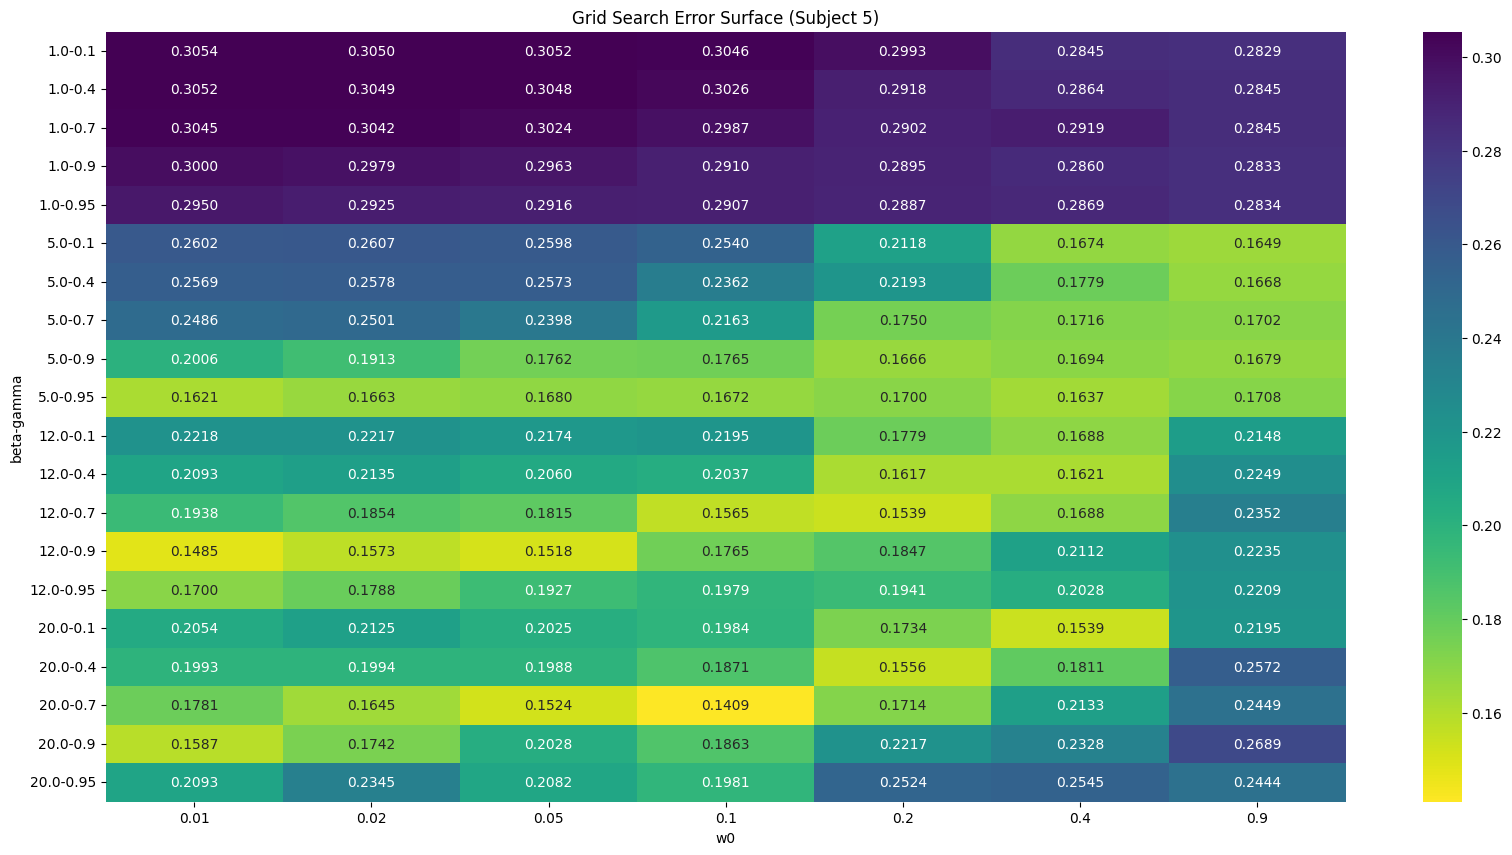

In [ ]:
# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot for heatmap (assuming 2D grid: gamma vs w0)
if "gamma" in df_results.columns and "w0" in df_results.columns:
    pivot_table = df_results.pivot(index=["beta", "gamma"], columns="w0", values="mean_error")
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis_r")
    plt.title(f"Grid Search Error Surface (Subject {subject_id})")
    plt.show()


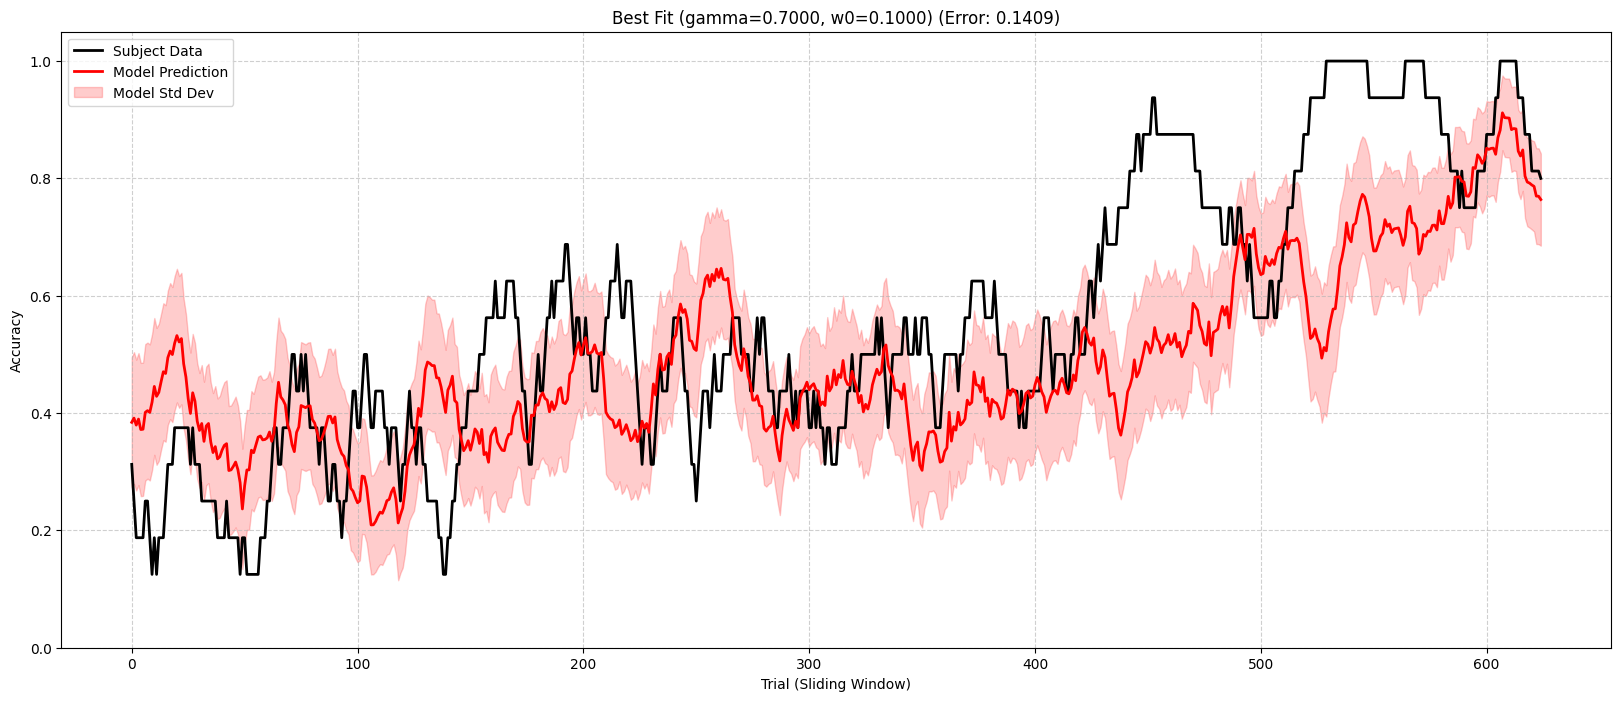

In [ ]:

# Plot Best
plot_result = best_result
title_prefix = f"Best Fit (gamma={best_result.params.get('gamma'):.4f}, w0={best_result.params.get('w0'):.4f})"

# Plot Fit Curve
plt.figure(figsize=(20, 8))
metrics = plot_result.metrics
sliding_true = metrics["sliding_true_acc"]
sliding_pred = metrics["sliding_pred_acc"]
sliding_std = metrics["sliding_pred_acc_std"]
trials = np.arange(len(sliding_true))

plt.plot(trials, sliding_true, label="Subject Data", color="black", linewidth=2)
plt.plot(trials, sliding_pred, label="Model Prediction", color="red", linewidth=2)

# Add confidence interval if available
if sliding_std is not None and not np.all(np.isnan(sliding_std)):
    plt.fill_between(
        trials, 
        sliding_pred - sliding_std, 
        sliding_pred + sliding_std, 
        color="red", 
        alpha=0.2,
        label="Model Std Dev"
    )

plt.xlabel("Trial (Sliding Window)")
plt.ylabel("Accuracy")
plt.title(f"{title_prefix} (Error: {plot_result.mean_error:.4f})")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 1.05)
plt.show()